In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
%matplotlib inline

In [2]:
filepath = "../dataset/20211124_100ppmdata/"
Data = []
for file in os.listdir(filepath):
    data = pd.read_excel(filepath+file)
    Data.append(data)
gas=[]
for i in range(len(Data)):
    gas.append(os.listdir(filepath)[i][0:4])

In [3]:
gas

['mo11',
 'mp11',
 'mxyl',
 'om13',
 'om31',
 'omp1',
 'omp1',
 'omp1',
 'omp2',
 'op11',
 'oxyl',
 'pm13',
 'pm31',
 'po13',
 'po31',
 'pxyl']

In [4]:
def data_preprocessing(Data,Col):
    New_Data=[]
    for i in range(len(Data)):
        data = Data[i]
        new_data = data.iloc[3:]
        new_data = new_data[Col[i]]
        New_Data.append(new_data)
    return New_Data


def choose_points(data,mode,zone,num_of_points):
    time = data['Time']
    matrix_mx3 = data[data.columns[1:]].values
    if mode==1:
        index = np.sum(time<zone)
        return matrix_mx3[max(0,index-num_of_points):index]
    elif mode==2:
        index1 = np.sum(time<zone[0])
        index2 = np.sum(time<zone[1])
        return matrix_mx3[index1:index2]
    
#mode=1时，zone:[1200,1200,1200] / 1200；mode=2时，zone为长度为2的列表
def X_and_y(Data,mode,zone,num_of_points=0):
    if type(zone)!=list:
        zone = [zone]*len(Data)
    length = len(Data[0].columns)-1
    X = np.empty([0,length])
    y = np.empty(0)
    label = 0
    for data in Data:
        label = label+1
        m = choose_points(data,mode,zone[label-1],num_of_points).shape[0]
        X = np.append(X,choose_points(data,mode,zone[label-1],num_of_points),axis=0)
        y = np.append(y,label*np.ones(m))
    Combine = np.hstack((X,y.reshape(-1,1)))
    np.random.shuffle(Combine)
    X = Combine[:,:-1]
    y = Combine[:,-1]
    y = y.astype(np.int)
    return (X,y)

def show_result(X,y,rate,k,sigma):
    while True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = rate)
        if np.all(np.unique(y_test)==np.unique(y_train)):
            break
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    y_pred = KNN(X_train,y_train,X_test,k,sigma)
    result = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(result)
    result1 = classification_report(y_test, y_pred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(y_test,y_pred)
    print("Accuracy:",result2)
    return result,result2

def many_times_test(X,y,times,rate=0.1,k=10,sigma=0.1):
    summe = 0
    summe2 = 0
    for i in range(times):
        result,result2=show_result(X,y,rate,k,sigma)
        summe = summe+result
        summe2 = summe2+result2
    print("The sum of all confusion matrices is:\n")
    print(summe)
    print('****************************************')
    print('Average Accuracy: ',summe2/times)
        
        
def find_k_nearst_neighbor(X_train,point,k,sigma):
    distances = np.sum((X_train-point)**2,axis=1)**0.5
    distances = 1/2*(distances-2*sigma+np.abs(distances-2*sigma))
    return np.argsort(distances)[:k]

def KNN(X_train,y_train,X_test,k,sigma):
    m = X_test.shape[0]
    y_pred = np.zeros(m)
    for i in range(m):
        neighbours = find_k_nearst_neighbor(X_train,X_test[i],k,sigma)
       # neighbours = neighbours.astype(np.int)
        counts = np.bincount(y_train[neighbours].astype(np.int))
        y_pred[i]=np.argmax(counts)
    return y_pred

def change_Data(Data,w):
    D=[]
    length = len(Data[0].columns)-1
    for data in Data:
        d = data.copy()
        for i in range(1,length+1):
            d['new'] = d.iloc[:,i].rolling(window=w).mean()
            d.iloc[:,i] = d['new']
        d = d.drop(columns='new')
        D.append(d.iloc[w-1:])
    return D 

def plot_kurve(Data,zone,num_of_points,Columns,sort=0,rolling=False,w = 5,mode=1):
    D = []
    length = len(Data[0].columns)-1
    if type(zone)!=list:
        zone = [zone]*len(Data)
    plt.figure(figsize=(15,6*len(Data)))
    for i in range(len(Data)):
        data = Data[i]
        time = data['Time'].values      
        if mode==1:
            time = time[time<zone[i]]
            time = time[-num_of_points:]
        elif mode==2:
            time = time[time<zone[-1]]
            time = time[time>zone[0]]
        d = pd.DataFrame(columns=data.columns)
        d['Time']=time[(w-1)*int(rolling):]
        if rolling:
            points = choose_points(data,mode,zone[i],num_of_points-w+1)
        else:
            points = choose_points(data,mode,zone[i],num_of_points)
        for column in range(length):
            d.iloc[:,column+1]=points[:,column]
        D.append(d)
        if sort!=0:
            for column in range(points.shape[1]):
                points[:,column] = points[:,column][np.argsort(points[:,column])] 
        plt.subplot(len(Data),1,i+1)
        for j in range(length):
            plt.plot(time[(w-1)*int(rolling):],points[:,j],'x',label = Columns[i][j+1]) 
        plt.legend()
        plt.title(gas[i])
    return D

def show_result2(X,y,n=2,times=10,rate=0.1):
    summe = 0
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = rate)
        lda = LDA(n_components=n)
        lda.fit(X_train,y_train)
        y_pred = lda.predict(X_test)
        result = confusion_matrix(y_test, y_pred)
        print("Confusion Matrix:")
        print(result)
        result1 = classification_report(y_test, y_pred)
        print("Classification Report:",)
        print (result1)
        result2 = accuracy_score(y_test,y_pred)
        print("Accuracy:",result2)
        summe = summe+result2
    print('****************************************')
    print('Average Accuracy: ',summe/100)
    X_new = lda.transform(X_test)
    if (n==2):
        for j in range(1,len(gas)+1):
            plt.scatter(X_new[y_test==j][:,0],X_new[y_test==j][:,1],label=gas[j-1])
        plt.legend()
    elif (n==3):
        fig = plt.figure(figsize=(15,10))
        ax = Axes3D(fig)
        for j in range(1,len(gas)+1):
            #ax.scatter(X_train[y_train==i][:,0], X_train[y_train==i][:,1],X_train[y_train==i][:,2], label=gas[i-1]+'_train')
            ax.scatter(X_new[y_test==j][:,0],X_new[y_test==j][:,1],X_new[y_test==j][:,1])
        #plt.legend()
    return X_new,y_test

In [5]:
#顺序是m o p
col1 = ['Time','c1','c2','c3','c4','c5','c6']
col2 = ['Time','c1','c2','c3','c4','c5','c6']
col3 = ['Time','c1','c2','c3','c4','c5','c6']
col4 = ['Time','c1','c2','c3','c4','c5','c6']
col5 = ['Time','c1','c2','c3','c4','c5','c6']
col6 = ['Time','c1','c2','c3','c4','c5','c6']
col7 = ['Time','c1','c2','c3','c4','c5','c6']
col8 = ['Time','c1','c2','c3','c4','c5','c6']
col9 = ['Time','c1','c2','c3','c4','c5','c6']
col10 = ['Time','c1','c2','c3','c4','c5','c6']
col11 = ['Time','c1','c2','c3','c4','c5','c6']
col12 = ['Time','c1','c2','c3','c4','c5','c6']
col13 = ['Time','c1','c2','c3','c4','c5','c6']
col14 = ['Time','c1','c2','c3','c4','c5','c6']
col15 = ['Time','c1','c2','c3','c4','c5','c6']
col16 = ['Time','c1','c2','c3','c4','c5','c6']
Col = [col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16]
Processed_Data = data_preprocessing(Data,Col)

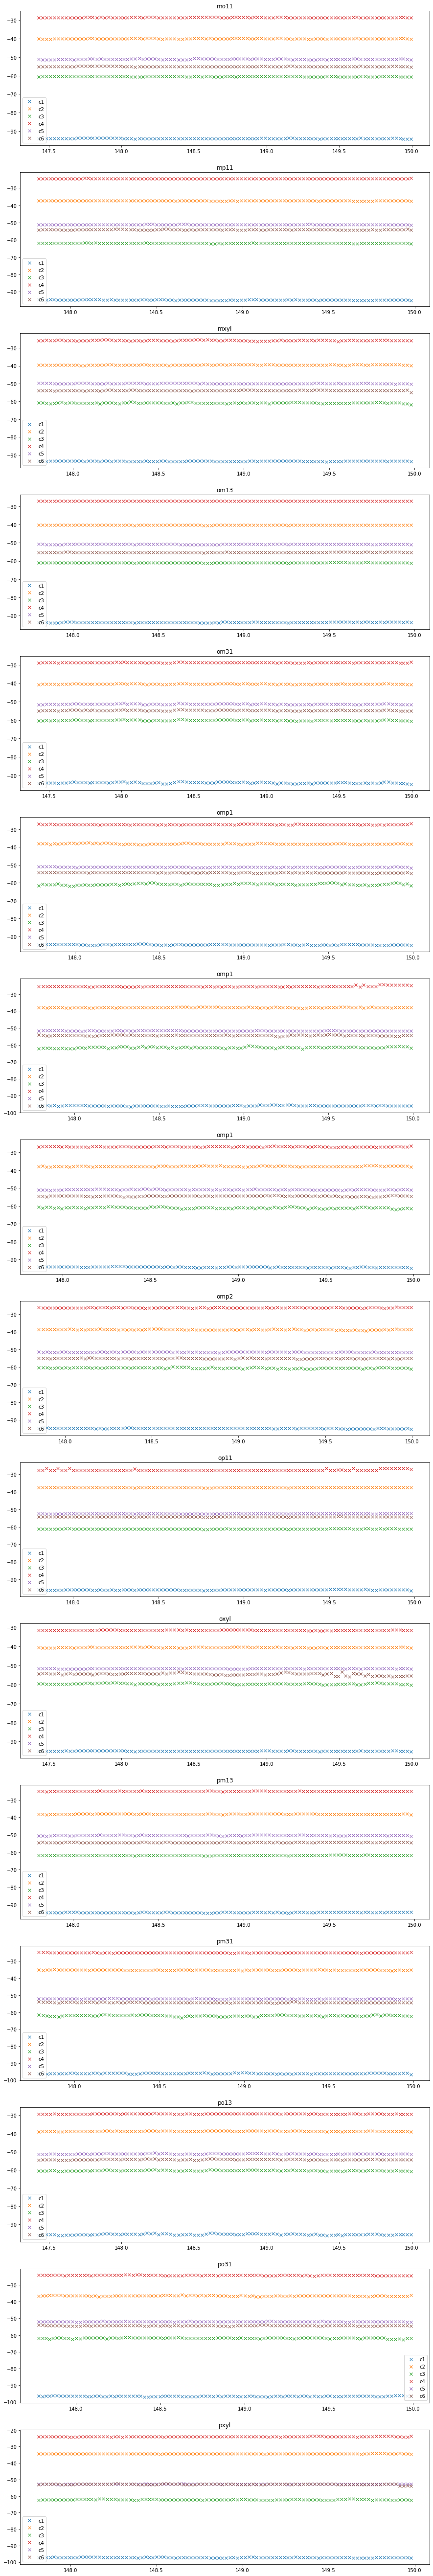

In [6]:
Dummy = plot_kurve(Processed_Data,zone=150,num_of_points=100,Columns=Col)

# KNN

In [12]:
X,y = X_and_y(Processed_Data,mode=1,zone=150,num_of_points=100)
many_times_test(X,y,times=10,rate=0.1,k=40,sigma=0.5)

Confusion Matrix:
[[ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 11  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 11  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14]]
Classification Report:
              precision    recall  f1-score   support

           1       0.88      1.00      0.93         7
           2       1.00      1.00

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.67      0.75         9
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00         8
           5       0.70      0.88      0.78         8
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        12
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00         9
          14       1.00      1.00      1.00         6
          15       1.00      1.00      1.00        13
          16       1.00      1.00      1.00        11

    accuracy                           0.97       157
   

# LDA

Confusion Matrix:
[[ 7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 11  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  6  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 13  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10]]
Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         7
           2       1.00      1.00

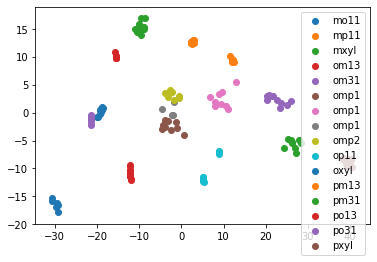

In [8]:
Dummy = show_result2(X,y,n=2,times=10,rate=0.1)